# ===========================================================
# Checking whether skills (individual performance) is correlated or caused given influence 
# ===========================================================

## Goals:
####   1. Compute individual performance (unweighted and hardness weighted)
####   2. Compute corr and causality of them with given influence by others to every member

#### Last update: 16 Dec 2019

# Imports

In [69]:
from __future__ import division, print_function, absolute_import, unicode_literals

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import networkx as nx
from collections import defaultdict
import sys
sys.path.insert(0, '../src/')
%matplotlib inline

from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests

import text_processor
import pogs_jeopardy_log_lib
import broadcast_network_extraction
import utils
from mytimer import Timer

/home/omid/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def reload():
    imp.reload(pogs_jeopardy_log_lib)
    imp.reload(text_processor)
    imp.reload(utils)
    imp.reload(broadcast_network_extraction)

In [3]:
reload()

In [4]:
# net_extractor = broadcast_network_extraction.NetworkExtraction()
# content_fixer = text_processor.FormalEnglishTranslator('../bagofwords/slang.txt')

# Parameters

In [5]:
directory = '/home/omid/Datasets/Jeopardy/'

# Helper functions

In [98]:
def get_normalized_influence_on_others(A: np.ndarray, index: int) -> float:
    A = np.array(A)
    return sum(
        A[[i for i in range(len(A))
           if i != index], index])

In [134]:
def compute_relationship(v1: np.ndarray, v2: np.ndarray) -> None:
    # Correlation.
    rval, pval = pearsonr(v1, v2)
    significant = ''
    if pval < 0.05:
        significant = 'yay!!!!'
    print('r-val: {}\np-val: {} \t{}'.format(rval, pval, significant))

    plt.scatter(v1, v2)
    plt.show()

    # It tests whether the time series in the second column Granger causes the time series in the first column.
    grangercausalitytests(
        np.column_stack((v1, v2)),
        maxlag=4)

# Loading teams' logs

In [100]:
data = utils.load_it(directory+'Teams_logs.pk')

In [268]:
hardness_weights = {
    pogs_jeopardy_log_lib.Level.EASY: 1,
    pogs_jeopardy_log_lib.Level.MEDIUM: 2,
    pogs_jeopardy_log_lib.Level.HARD: 3}
minimum_number_of_questions_to_answer = 44

questions = data[37].game_info.questions
individual_performances = {}
for team_id, team_log in data.items():
    individual_performances[team_id] = defaultdict(
        lambda: {'#correct': 0,
                 '#questions': 0,
                 '#hardness_weighted_correct': 0,
                 '#hardness_weighted_questions': 0})
    for qid, team_answers in team_log.individual_answers_chosen.items():
        hardness_weight = hardness_weights[questions[qid].level]
        for member in team_log.members:
            if member in team_answers:
                individual_performances[team_id][member]['#questions'] += 1
                individual_performances[team_id][member]['#hardness_weighted_questions'] += hardness_weight
                if questions[qid].answer == team_answers[member]:
                    individual_performances[team_id][member]['#correct'] += 1
                    individual_performances[team_id][member]['#hardness_weighted_correct'] += hardness_weight
individual_performance_rates = defaultdict(dict)
for team_id, team_log in data.items():
    for member in team_log.members:
        if individual_performances[team_id][member]['#questions'] >= minimum_number_of_questions_to_answer:
            correct_rate = individual_performances[team_id][member]['#correct'] / individual_performances[team_id][member]['#questions']
            hardness_weighted_correct_rate = individual_performances[team_id][member]['#hardness_weighted_correct'] / individual_performances[team_id][member]['#hardness_weighted_questions']
            individual_performance_rates[team_id][member] = {
                'correct_rate': correct_rate,
                'hardness_weighted_correct_rate': hardness_weighted_correct_rate}

In [269]:
len(individual_performance_rates)

31

In [270]:
amount_of_appraise_by_others_vector = []
inidividual_performance_vector = []
inidividual_weighted_performance_vector = []
for team_id, team_log in data.items():
    if team_id in individual_performance_rates:
        if len(team_log.member_influences) < 1 or np.sum(team_log.member_influences_from_data[-1]) != 16:
            continue
        influence_matrix = utils.make_matrix_row_stochastic(
            np.matrix(team_log.member_influences[-1]) / 100)
#         if len(team_log.member_influences) < 2 or np.sum(team_log.member_influences_from_data[-1]) != 16 or np.sum(team_log.member_influences_from_data[-2]) != 16:
#             continue
#         influence_matrix = utils.make_matrix_row_stochastic(
#             (np.matrix(team_log.member_influences[-1]) + np.matrix(team_log.member_influences[-2])) / 200)
        for index, member in enumerate(team_log.members):
            if member in individual_performance_rates[team_id]:
                amount_of_appraise_by_others_vector.append(
                    get_normalized_influence_on_others(
                        influence_matrix, index))
                inidividual_performance_vector.append(
                    individual_performance_rates[team_id][member]['correct_rate'])
                inidividual_weighted_performance_vector.append(
                    individual_performance_rates[team_id][member]['hardness_weighted_correct_rate'])
amount_of_appraise_by_others_vector = np.array(amount_of_appraise_by_others_vector)
inidividual_performance_vector = np.array(inidividual_performance_vector)
inidividual_weighted_performance_vector = np.array(inidividual_weighted_performance_vector)

In [271]:
len(amount_of_appraise_by_others_vector)

116

r-val: -0.18720556825543863
p-val: 0.044192842577459146 	yay!!!!


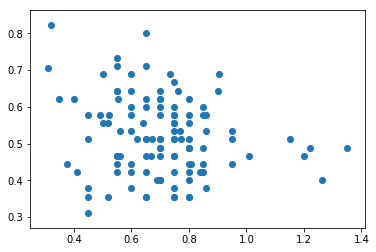


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4349  , p=0.5109  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.4466  , p=0.5040  , df=1
likelihood ratio test: chi2=0.4457  , p=0.5044  , df=1
parameter F test:         F=0.4349  , p=0.5109  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1837  , p=0.8324  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=0.3843  , p=0.8252  , df=2
likelihood ratio test: chi2=0.3836  , p=0.8255  , df=2
parameter F test:         F=0.1837  , p=0.8324  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0829  , p=0.9692  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=0.2650  , p=0.9665  , df=3
likelihood ratio test: chi2=0.2647  , p=0.9665  , df=3
parameter F test:         F=0.0829  , p=0.9692  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4722  , p=0.7560  

In [272]:
compute_relationship(amount_of_appraise_by_others_vector, inidividual_performance_vector)

r-val: -0.19750765841285636
p-val: 0.033572696068435375 	yay!!!!


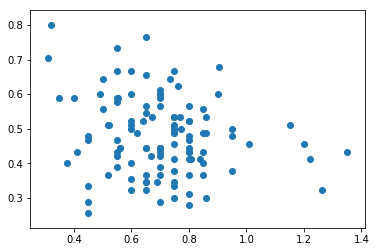


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3251  , p=0.5697  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.3338  , p=0.5634  , df=1
likelihood ratio test: chi2=0.3333  , p=0.5637  , df=1
parameter F test:         F=0.3251  , p=0.5697  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1792  , p=0.8362  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=0.3749  , p=0.8291  , df=2
likelihood ratio test: chi2=0.3743  , p=0.8293  , df=2
parameter F test:         F=0.1792  , p=0.8362  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0628  , p=0.9793  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=0.2009  , p=0.9774  , df=3
likelihood ratio test: chi2=0.2008  , p=0.9775  , df=3
parameter F test:         F=0.0628  , p=0.9793  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2506  , p=0.9087  

In [273]:
compute_relationship(amount_of_appraise_by_others_vector, inidividual_weighted_performance_vector)

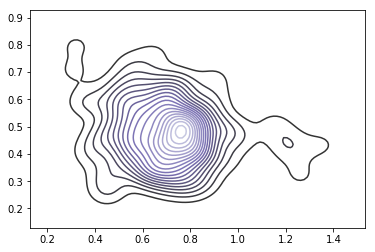

In [274]:
sns.kdeplot(
    amount_of_appraise_by_others_vector,
    inidividual_weighted_performance_vector,
    n_levels=20, cmap="Purples_d")

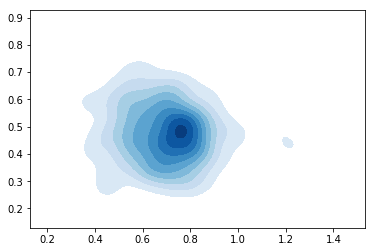

In [275]:
sns.kdeplot(
    amount_of_appraise_by_others_vector,
    inidividual_weighted_performance_vector,
    cmap="Blues", shade=True, shade_lowest=False)

In [276]:
dt = pd.DataFrame(
    {'Appraise_by_others': amount_of_appraise_by_others_vector,
     'Inidividual_weighted_performance': inidividual_weighted_performance_vector})

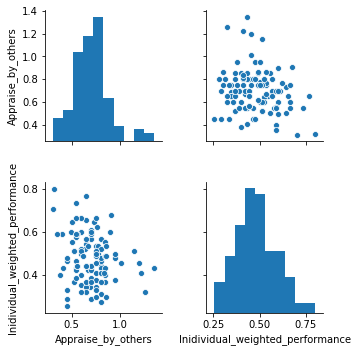

In [277]:
sns.pairplot(dt);